<a href="https://colab.research.google.com/github/ELYAHYAOUY-FL/Diffusion_Prediction_Service/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split


In [112]:
# Load the first 1000 rows of the dataset
data_path = '/content/Unicauca-dataset-April-June-2019-Network-flows.csv'
df = pd.read_csv(data_path, nrows=5000)

# Initial data overview
print("Initial Dataset Shape:", df.shape)
print("Columns with Missing Values:\n", df.isnull().sum())


Initial Dataset Shape: (5000, 50)
Columns with Missing Values:
 flow_key                0
src_ip_numeric          0
src_ip                  0
src_port                0
dst_ip                  0
dst_port                0
proto                   0
pktTotalCount           0
octetTotalCount         0
min_ps                  0
max_ps                  0
avg_ps                  0
std_dev_ps              0
flowStart               0
flowEnd                 0
flowDuration            0
min_piat                0
max_piat                0
avg_piat                0
std_dev_piat            0
f_pktTotalCount         0
f_octetTotalCount       0
f_min_ps                0
f_max_ps                0
f_avg_ps                0
f_std_dev_ps            0
f_flowStart             0
f_flowEnd               0
f_flowDuration          0
f_min_piat              0
f_max_piat              0
f_avg_piat              0
f_std_dev_piat          0
b_pktTotalCount         0
b_octetTotalCount       0
b_min_ps                0


In [113]:
# Impute numerical columns with median and categorical columns with the most frequent value
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


In [114]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [115]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, numerical_cols)


In [116]:
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

print("Preprocessed Dataset Shape:", df.shape)


Preprocessed Dataset Shape: (2722, 50)


Graph constructed with 230 nodes and 240 edges.


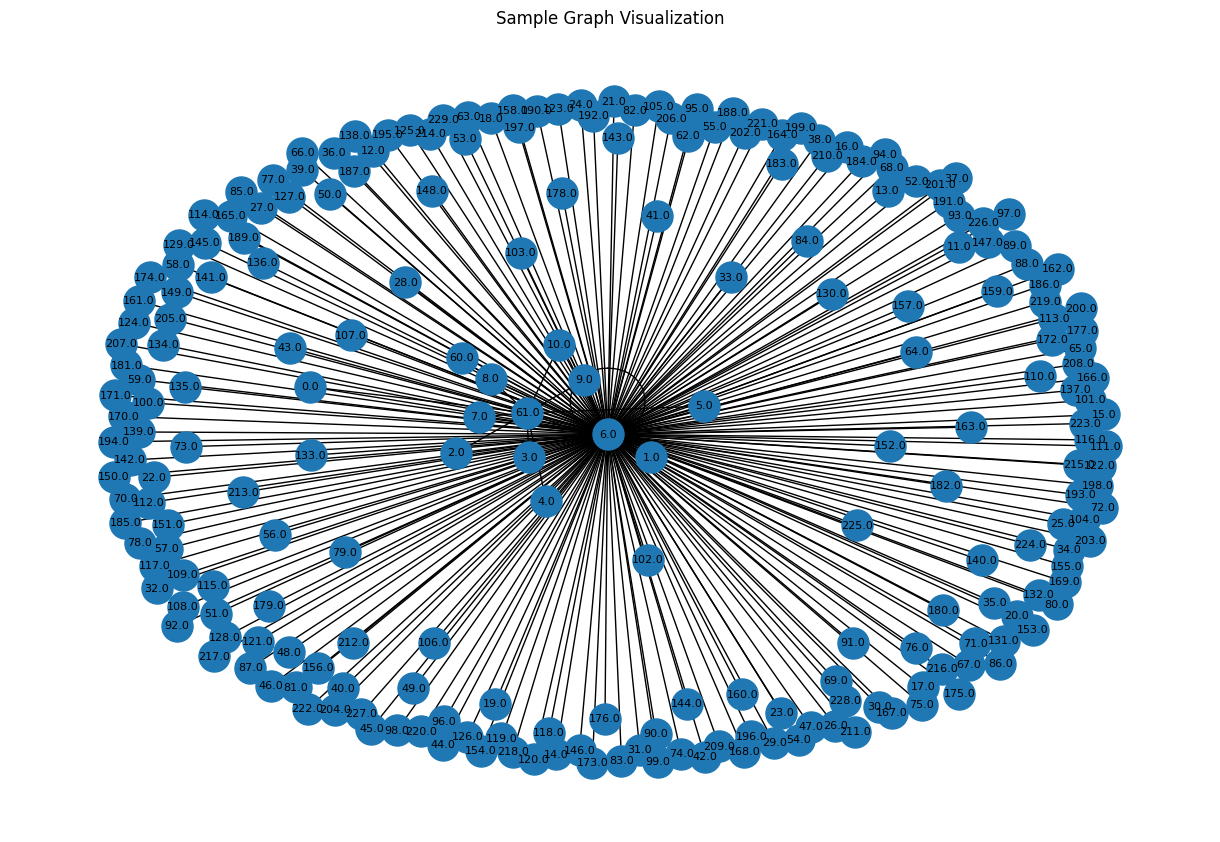

In [117]:
# Create a graph
G = nx.Graph()

# Add edges based on communication data
for _, row in df.iterrows():
    src_ip = row['src_ip']
    dst_ip = row['dst_ip']
    weight = row['pktTotalCount']  # Edge weight

    if not G.has_edge(src_ip, dst_ip):
        G.add_edge(src_ip, dst_ip, weight=weight)
    else:
        G[src_ip][dst_ip]['weight'] += weight

print(f"Graph constructed with {len(G.nodes)} nodes and {len(G.edges)} edges.")


# Visualize a subset of the graph
plt.figure(figsize=(12, 8))
subgraph = nx.subgraph(G, list(G.nodes)[:1000])  # Visualize a subset of the graph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=8)
plt.title("Sample Graph Visualization")
plt.show()


In [118]:
def simulate_diffusion(G, initial_infected, infection_prob, steps=10):
    infection_states = {node: 0 for node in G.nodes}
    for node in initial_infected:
        infection_states[node] = 1

    infection_history = [infection_states.copy()]
    for _ in range(steps):
        new_states = infection_states.copy()
        for node in G.nodes:
            if infection_states[node] == 1:
                for neighbor in G.neighbors(node):
                    if infection_states[neighbor] == 0:
                        if random.random() < infection_prob:
                            new_states[neighbor] = 1
        infection_states = new_states
        infection_history.append(infection_states.copy())

    return infection_history

# Simulate infection spread
initial_infected = [random.choice(list(G.nodes))]
infection_prob = 0.3
infection_history = simulate_diffusion(G, initial_infected, infection_prob, steps=10)
print(infection_history)


[{3.0: 0, 61.0: 0, 7.0: 0, 8.0: 0, 60.0: 0, 9.0: 0, 10.0: 0, 0.0: 0, 1.0: 0, 2.0: 0, 4.0: 0, 5.0: 0, 6.0: 0, 118.0: 0, 190.0: 0, 45.0: 0, 11.0: 0, 223.0: 0, 58.0: 0, 50.0: 0, 141.0: 0, 155.0: 0, 129.0: 0, 146.0: 0, 136.0: 0, 201.0: 0, 206.0: 0, 69.0: 0, 226.0: 0, 71.0: 0, 23.0: 0, 195.0: 0, 175.0: 0, 177.0: 0, 128.0: 0, 229.0: 0, 215.0: 0, 131.0: 0, 96.0: 0, 183.0: 0, 76.0: 0, 89.0: 0, 85.0: 0, 101.0: 0, 29.0: 1, 75.0: 0, 16.0: 0, 164.0: 0, 158.0: 0, 219.0: 0, 39.0: 0, 110.0: 0, 168.0: 0, 34.0: 0, 53.0: 0, 28.0: 0, 88.0: 0, 222.0: 0, 187.0: 0, 63.0: 0, 199.0: 0, 43.0: 0, 119.0: 0, 193.0: 0, 184.0: 0, 49.0: 0, 152.0: 0, 14.0: 0, 150.0: 0, 15.0: 0, 159.0: 0, 127.0: 0, 56.0: 0, 67.0: 0, 225.0: 0, 145.0: 0, 139.0: 0, 132.0: 0, 22.0: 0, 174.0: 0, 176.0: 0, 18.0: 0, 130.0: 0, 204.0: 0, 198.0: 0, 228.0: 0, 114.0: 0, 165.0: 0, 107.0: 0, 91.0: 0, 84.0: 0, 179.0: 0, 103.0: 0, 109.0: 0, 78.0: 0, 169.0: 0, 74.0: 0, 125.0: 0, 211.0: 0, 217.0: 0, 157.0: 0, 82.0: 0, 26.0: 0, 33.0: 0, 41.0: 0, 87.0: 0

In [119]:
def prepare_training_data(G, infection_history):
    X = []
    y = []

    for t in range(1, len(infection_history)):
        current_state = infection_history[t - 1]
        next_state = infection_history[t]

        for node in G.nodes:
            features = [
                G.degree[node],
                current_state[node],
                np.mean([current_state[neighbor] for neighbor in G.neighbors(node)]),
            ]
            X.append(features)
            y.append(next_state[node])

    return np.array(X), np.array(y)

X, y = prepare_training_data(G, infection_history)


In [120]:
print("IP addresses in the graph:", list(G.nodes)[:10])  # Print the first 10 IPs


IP addresses in the graph: [3.0, 61.0, 7.0, 8.0, 60.0, 9.0, 10.0, 0.0, 1.0, 2.0]


Accuracy: 0.9043478260869565
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       209
           1       1.00      0.86      0.93       481

    accuracy                           0.90       690
   macro avg       0.88      0.93      0.89       690
weighted avg       0.93      0.90      0.91       690

Encoded IP 0 is found in the graph.


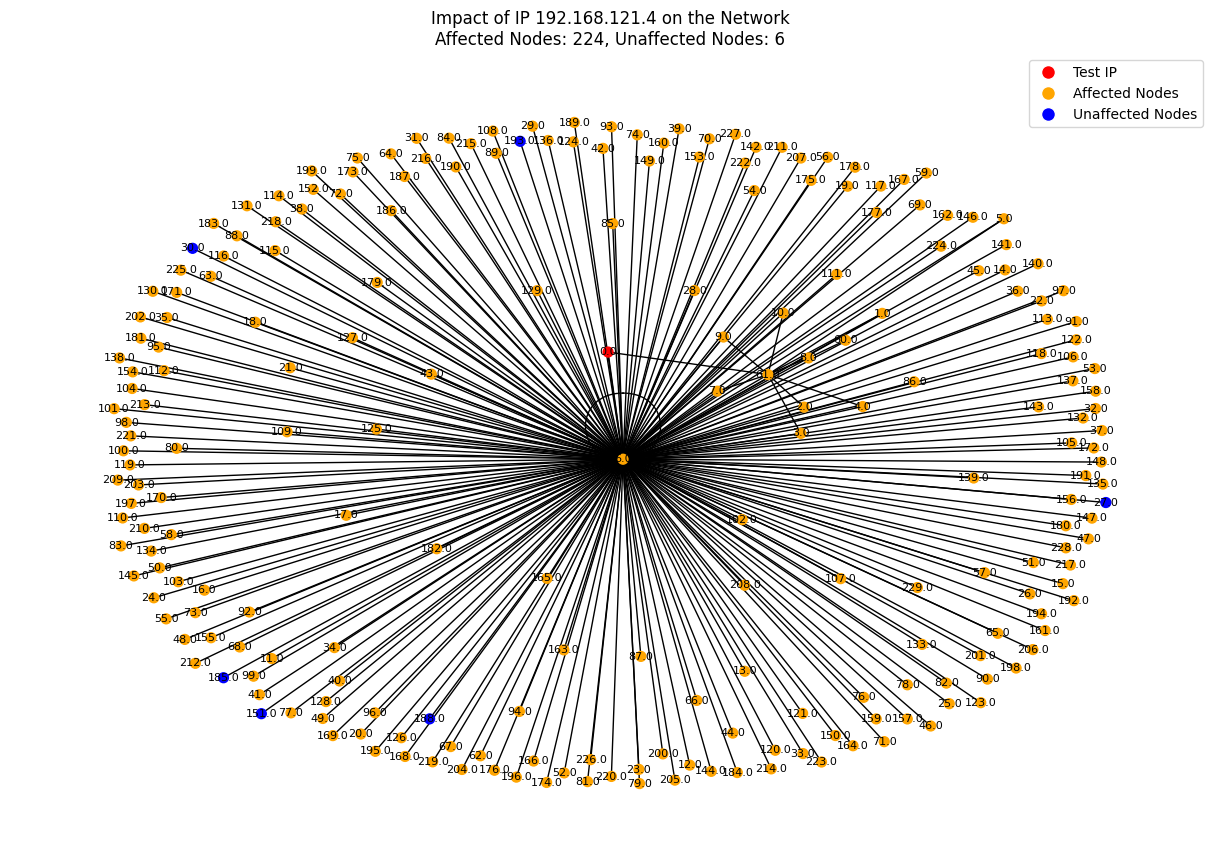

In [125]:
# Prepare training data
X, y = prepare_training_data(G, infection_history)

# Now, split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


# Assuming that the training data includes multiple features (e.g., degree, centrality, etc.)
# Function to prepare features for nodes
def extract_features(G):
    features = []
    for node in G.nodes:
        # Example features: degree, betweenness centrality, and closeness centrality
        degree = G.degree[node]
        betweenness = nx.betweenness_centrality(G).get(node, 0)
        closeness = nx.closeness_centrality(G).get(node, 0)
        features.append([degree, betweenness, closeness])  # Combine features
    return np.array(features)

# Updated function to test the effect of a specific IP
def test_ip_impact(G, model, test_ip, infection_prob=0.3, steps=10):
    """
    Test how a specific IP affects the network.
    Args:
        G (networkx.Graph): The network graph.
        model (RandomForestClassifier): Trained diffusion model.
        test_ip (str): IP to test.
        infection_prob (float): Probability of infection spread.
        steps (int): Number of steps to simulate.

    Returns:
        dict: Predicted states of the IP and its neighbors.
    """
    if test_ip not in G.nodes:
        print(f"IP {test_ip} not found in the graph.")
        return None

    # Initialize infection state for test IP
    initial_infected = [test_ip]
    infection_history = simulate_diffusion(G, initial_infected, infection_prob, steps)

    # Extract the final infection states
    final_infection_states = infection_history[-1]

    # Extract the features for all nodes (same as used for training)
    features = extract_features(G)

    # Predict infection states for each node using the model
    predictions = model.predict(features)

    # Combine predictions with the final infection states
    results = {node: final_infection_states[node] for node in G.nodes}
    return results



# Visualize the impact with a key for affected and unaffected nodes
def visualize_impact(G, test_ip, encoded_ip, impact_results):
    """
    Visualize the impact of a specific IP on the network, including a key.
    """
    # Count affected and unaffected nodes
    affected_count = sum(1 for node in G.nodes if impact_results.get(node, 0) == 1)
    unaffected_count = len(G.nodes) - affected_count

    # Node colors
    node_colors = [
        "red" if node == encoded_ip else
        ("orange" if impact_results.get(node, 0) == 1 else "blue")
        for node in G.nodes
    ]

    # Generate layout and draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=50,
        font_size=8
    )

    # Add a legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Test IP', markerfacecolor='red', markersize=10)
    orange_patch = plt.Line2D([0], [0], marker='o', color='w', label='Affected Nodes', markerfacecolor='orange', markersize=10)
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Unaffected Nodes', markerfacecolor='blue', markersize=10)
    plt.legend(handles=[red_patch, orange_patch, blue_patch], loc="upper right")

    # Add title with counts
    plt.title(f"Impact of IP {test_ip} on the Network\n"
              f"Affected Nodes: {affected_count}, Unaffected Nodes: {unaffected_count}")

    # Show the plot
    plt.show()



# Test the impact of a specific IP
test_ip = "192.168.121.4"  # Replace with a valid IP from the list

# Encode the IP address
encoded_ip = encoder.fit_transform([test_ip])[0]  # Transform returns a list; get the first element

# Check if the encoded IP exists in the graph
if encoded_ip in G.nodes:
    print(f"Encoded IP {encoded_ip} is found in the graph.")

    # Test the impact using the encoded IP
    impact_results = test_ip_impact(G, clf, encoded_ip)

    # Visualize the impact
    if impact_results:
          visualize_impact(G, test_ip,encoded_ip,impact_results)
    else:
        print("No impact results available.")
else:
    print(f"Encoded IP {encoded_ip} is not found in the graph.")





# Visualize the results
